In [610]:
%matplotlib inline

import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model, model_selection, pipeline, decomposition, ensemble, svm

In [413]:
df = pd.read_pickle('./process.pkl')
cn = {v:k for v,k in enumerate(df.columns)}
cn

{0: 'Time',
 1: 'Main Engine Fuel Consumption (MT/day)',
 2: 'Main Engine Using HFO (bool)',
 3: 'Main Engine Using MGO (bool)',
 4: 'Draft Forward (meters)',
 5: 'Draft Aft (meters)',
 6: 'Draft Mid-1 (meters)',
 7: 'Draft Mid-2 (meters)',
 8: 'Shaft Speed (RPM)',
 9: 'Shaft Torque (kNm)',
 10: 'Shaft Power (kW)',
 11: 'Speed Over Ground (knots)',
 12: 'Speed Through Water (knots)',
 13: 'Heading (degrees)',
 14: 'Rudder Angle (degrees)',
 15: 'Weather Service Apparent Wind Speed (knots)',
 16: 'Weather Service Apparent Wind Direction (degrees from bow)',
 17: 'Weather Service True Wind Speed (knots)',
 18: 'Weather Service True Wind Direction (degrees from north)',
 19: 'Weather Service Temperature (celsius)',
 20: 'Water Depth (meters)',
 21: 'datetime',
 22: 'contig',
 23: 'trip',
 24: 'heading_delta',
 25: 'active',
 26: 'trim',
 27: 'rudder',
 28: 'depth',
 29: 'current',
 30: 'bowWind_sine',
 31: 'bowWind_cos',
 32: 'heading_delta2',
 33: 'wind_speed'}

In [414]:
from sklearn.base import BaseEstimator, TransformerMixin
class ColSelector(BaseEstimator, TransformerMixin):
    def __init__(self, colNames):
        self.colNames = colNames
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.colNames].values.astype(float)

In [415]:
c=ColSelector(['depth','rudder','trim','bowWind_sine','bowWind_cos','heading_delta2','wind_speed'])
x = c.transform(df)

In [1016]:
test = [4,136,224,196,212,292,310,354]
        
df_test = df[df.trip.isin(test)]
df      = df[~df.trip.isin(test)]

gkf = model_selection.GroupKFold(4)
g = list(gkf.split(X=df.trip,groups=df.trip))

In [1127]:
cols = ['wind_speed','bowWind_cos','bowWind_sine','current',
        'depth','rudder','trim','heading_delta2', 
        cn[12],cn[4]
       ]



power = [ ('power',ColSelector(cols)),
          #('normalize',preprocessing.StandardScaler()),
          ('fit',linear_model.LinearRegression())
        ]

p = pipeline.Pipeline(steps=power)


In [1151]:
p_grid = [ {'fit':[linear_model.LinearRegression(),
                   #ensemble.RandomForestRegressor(n_estimators=100,max_depth=8,oob_score=True)
                  ],
               }
             ]




xvalid = model_selection.GridSearchCV(p,p_grid,cv=g)

xvalid = xvalid.fit(df, df[cn[1]].values)


In [1152]:
test = [142., 230., 228., 232., 192., 326., 176., 256., 328., 270.,188]
df.trip.unique()

array([  2.,  10.,  12.,  16.,  18.,  22.,  36., 126., 130., 132., 166.,
       168., 178., 184., 188., 198., 202., 206., 208., 210., 216., 220.,
       226., 238., 240., 250., 258., 260., 262., 264., 266., 268., 272.,
       274., 276., 282., 286., 288., 290., 300., 302., 304., 306., 314.,
       348., 352.])

In [1177]:
e = xvalid.best_estimator_
e = e.fit(df, df[cn[1]].values)

y_pred = e.predict(df_test)
e.score(df_test,df_test[cn[1]])

0.903587658684777

In [1154]:
e

Pipeline(memory=None,
     steps=[('power', ColSelector(colNames=['wind_speed', 'bowWind_cos', 'bowWind_sine', 'current', 'depth', 'rudder', 'trim', 'heading_delta2', 'Speed Through Water (knots)', 'Draft Forward (meters)'])), ('fit', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

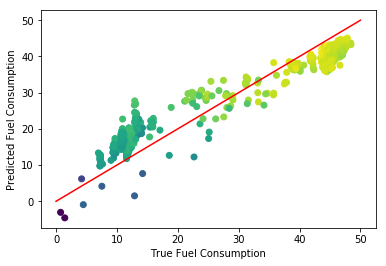

In [1155]:
#import seaborn as sns

#cmap = sns.cubehelix_palette(as_cmap=True)

plt.scatter(df_test[cn[1]].values, y_pred, c=df_test[cn[12]])
plt.plot(np.linspace(0,50,2),np.linspace(0,50,2),'r')
plt.ylabel('Predicted Fuel Consumption')
plt.xlabel('True Fuel Consumption')
plt.savefig('/Users/frjo6001/Desktop/fig.pdf',format='pdf')

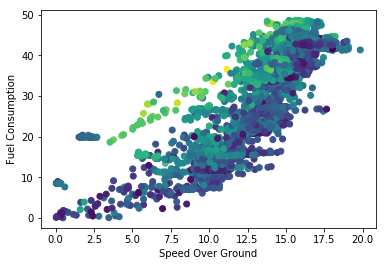

In [1156]:
plt.scatter(df[cn[11]], df[cn[1]], c=df[cn[15]])
plt.ylabel('Fuel Consumption')
plt.xlabel('Speed Over Ground')
plt.savefig('/Users/frjo6001/Desktop/fig.pdf',format='pdf')

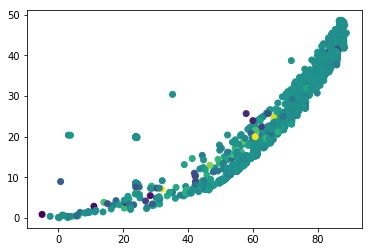

In [1157]:
plt.scatter(df[cn[8]], df[cn[1]], c=df[cn[24]])

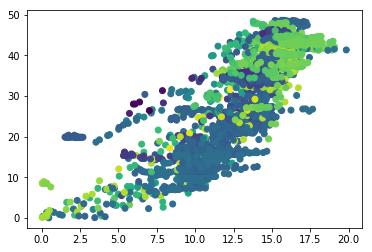

In [1158]:
plt.scatter(df[cn[12]], df[cn[1]], c=df[cn[4]])

ValueError: x and y must be the same size

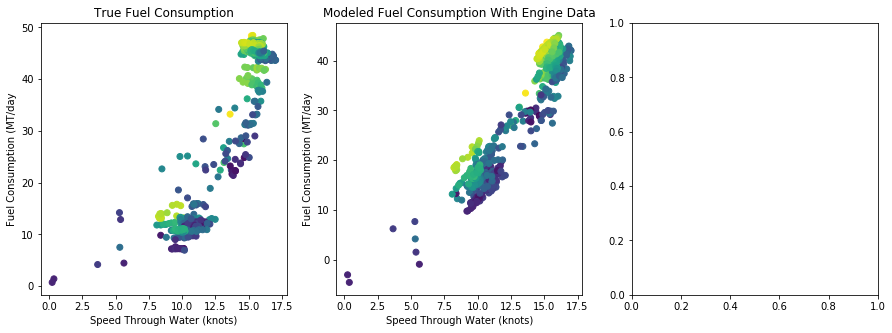

In [1159]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(df_test[cn[12]],df_test[cn[1]], c=df_test[cn[15]])
plt.title('True Fuel Consumption')
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Fuel Consumption (MT/day')
plt.subplot(132)
plt.scatter(df_test[cn[12]],y_pred, c=df_test[cn[15]])
plt.title('Modeled Fuel Consumption With Engine Data')
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Fuel Consumption (MT/day')

plt.subplot(133)
plt.scatter(df_test[cn[12]],y_pred2, c=df_test[cn[15]])
plt.title('Modeled Fuel Consumption No Engine Data')
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Fuel Consumption (MT/day')

plt.savefig('/Users/frjo6001/Desktop/fig.pdf',format='pdf')

In [ ]:
plt.scatter(df_test[cn[12]],df_test[cn[1]], c=df_test[cn[15]])

In [ ]:
df_test[cn[15]].min(); cn[15]

In [ ]:
xvalid.cv_results_

In [1160]:
df_test_zero_wind = copy.deepcopy(df_test)
df_test_zero_wind[cn[15]] = 0

y_pred_no_wind = e.predict(df_test_zero_wind)

Text(0,0.5,'Fuel Consumption (MT/day')

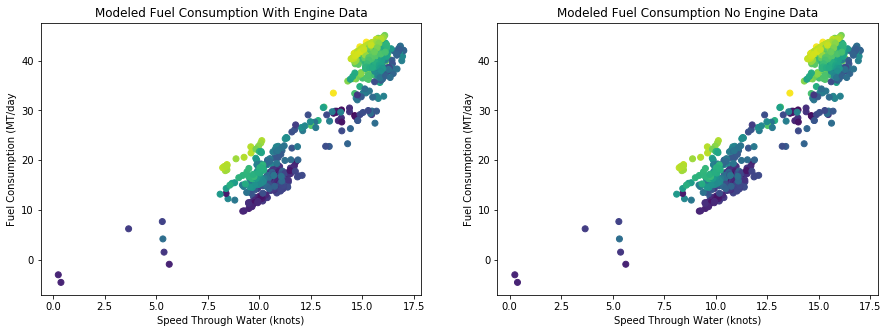

In [1161]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.scatter(df_test[cn[12]],y_pred, c=df_test[cn[15]])
plt.title('Modeled Fuel Consumption With Engine Data')
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Fuel Consumption (MT/day')

plt.subplot(122)
plt.scatter(df_test[cn[12]],y_pred_no_wind, c=df_test[cn[15]])
plt.title('Modeled Fuel Consumption No Engine Data')
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Fuel Consumption (MT/day')

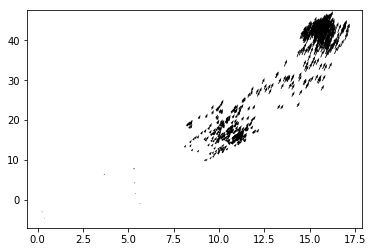

In [1162]:
plt.quiver(df_test[cn[12]],
           y_pred,
           df_test[cn[12]],
           y_pred_no_wind
          )
plt.savefig('/Users/frjo6001/Desktop/t.pdf',format='pdf')

In [1163]:
RF=e.steps[-1][1]
RF.feature_importances_

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [1164]:
cn[11],cn[4]

('Speed Over Ground (knots)', 'Draft Forward (meters)')

In [1165]:
order = np.argsort(RF.feature_importances_)[::-1].astype(int)

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [1166]:
RF.feature_importances_[order]

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [1167]:
o=[]
for i in order:
    o.append(cols[i])

In [1168]:
plt.barh(range(4), RF.feature_importances_[order][0:4])
plt.yticks(range(4),o[0:4])
plt.xlabel('Relative Feature Importance')
plt.tight_layout()
plt.savefig('/Users/frjo6001/Desktop/t.pdf',format='pdf')

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [1169]:
df_comp = copy.deepcopy(df_test)

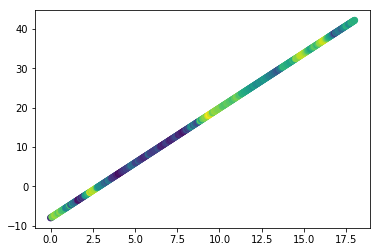

In [1180]:
for c in cols:
    df_comp[c]=np.mean(df[c])
    
df_comp[cn[12]]= np.linspace(0,18,df_comp[cn[12]].shape[0])

y_pred5 = e.predict(df_comp)

plt.scatter( df_comp[cn[12]], y_pred5, c=df_test[cn[15]])

In [1176]:

cn[12]

'Speed Through Water (knots)'

In [1115]:
df[cn[15]].max()

51.955334756046504